# Billboard Chart

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

%matplotlib inline

### Import data

In [2]:
music = pd.read_csv('assets/billboard.csv')
music.head(2)

,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,"3,38,00 AM",Rock,"September 23, 2000","November 18, 2000",78,63,49,...,*,*,*,*,*,*,*,*,*,*
1,2000,Santana,"Maria, Maria","4,18,00 AM",Rock,"February 12, 2000","April 8, 2000",15,8,6,...,*,*,*,*,*,*,*,*,*,*


In [3]:
music.dtypes[0:8]

year                int64
artist.inverted    object
track              object
time               object
genre              object
date.entered       object
date.peaked        object
x1st.week           int64
dtype: object

In [4]:
## remove 'year' column if all values are the same
try:
    if len(set(music['year'])) == 1:
        music.drop(['year'], axis = 1, inplace = True)
    else:
        print len(set(music['year']))
except: 
    pass

In [5]:
for i in range(len(music['track'].value_counts(ascending = False))):
    if music['track'].value_counts(ascending = False)[i] > 1:
        print music[music['track'] == music['track'].value_counts(ascending = False).index[i]]\
            [['artist.inverted', 'track']]

    artist.inverted             track
118   Jones, Donell  Where I Wanna Be
305   Sheist, Shade  Where I Wanna Be


In [6]:
music['genre'].value_counts()

Rock           103
Country         74
Rap             58
Rock'n'roll     34
R&B             13
R & B           10
Pop              9
Latin            9
Electronica      4
Gospel           1
Jazz             1
Reggae           1
Name: genre, dtype: int64

Check out singletons:

In [7]:
music[(music['genre'] == 'Gospel') |\
      (music['genre'] == 'Jazz') |\
      (music['genre'] == 'Reggae')][['artist.inverted', 'track', 'genre']]

,artist.inverted,track,genre
49,Kenny G,Auld Lang Syne (The Millenium Mix),Jazz
189,Beenie Man,Girls Dem Sugar,Reggae
200,"Adams, Yolanda",Open My Heart,Gospel


In [8]:
music['genre'] = music['genre'].apply(lambda x: x.replace('Rock\'n\'roll', 'Rock'))
music['genre'] = music['genre'].apply(lambda x: x.replace('R & B', 'R&B'))
music['genre'] = music['genre'].astype('category')
music['genre'].value_counts()

Rock           137
Country         74
Rap             58
R&B             23
Pop              9
Latin            9
Electronica      4
Reggae           1
Jazz             1
Gospel           1
Name: genre, dtype: int64

In [9]:
def fix_name(artist):
    try:
        name = artist.split(', ')
        new_name = "%s" %name[1] + " %s" %name[0]
    except:
        new_name = artist
    return new_name

In [10]:
music['artist.inverted'] = music['artist.inverted'].apply(lambda x: fix_name(x))
music = music.rename(columns={'artist.inverted': 'artist'})

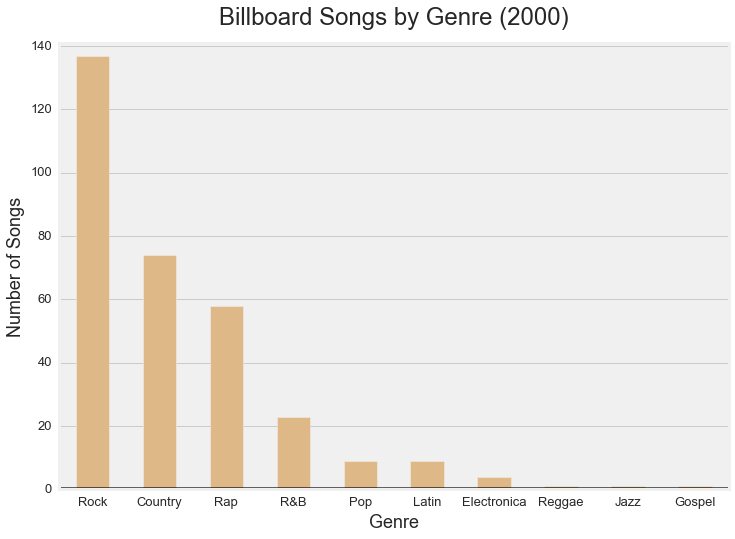

In [11]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y = pd.DataFrame(music['genre'].value_counts())

y['genre'].plot.bar(color = 'burlywood')

plt.title('Billboard Songs by Genre (2000)', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Number of Songs', fontsize = 18)
plt.yticks(range(0, 160, 20), fontsize = 13)
plt.ylim([0, 141])

# x label
plt.xlabel('Genre', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=0, fontsize = 13)

plt.grid(which = 'major', axis = 'x')


plt.show()

Let's make a column for entering chart position, which we'll use it to calculate time to peak position:

In [12]:
music['entering_position'] = music['x1st.week'].apply(lambda x: float(x))

Clean column of track lengths:

In [13]:
music['time'].max() 

'7,50,00 AM'

In [14]:
music['time'] = music['time'].apply(lambda x: x.replace(',00 AM', ''))

In [15]:
def get_sec(s):
    try:
        time = s.split(',')
        new_s = float(int(time[0]) * 60 + int(time[1]))
    except:
        new_s = s
    return new_s

In [16]:
music['time'] = music['time'].apply(lambda x: get_sec(x))
music[['artist', 'track', 'time', 'genre']].head(2)

,artist,track,time,genre
0,Destiny's Child,Independent Women Part I,218.0,Rock
1,Santana,"Maria, Maria",258.0,Rock


In [17]:
music['date.entered'] = music['date.entered'].apply(lambda x: pd.to_datetime(x))
music['date.peaked'] = music['date.peaked'].apply(lambda x: pd.to_datetime(x))
music = music.rename(columns = {
        'date.entered' : 'date_entered', 
        'date.peaked' : 'date_peaked'})

In [18]:
music['weeks_to_peak'] = ((music['date_peaked']-music['date_entered'])/7)\
                                                            .apply(lambda x: float(x.days))
music['weeks_to_peak'].head()

0     8.0
1     8.0
2    14.0
3     5.0
4    10.0
Name: weeks_to_peak, dtype: float64

### Visualize Data

Find peak position attained by each track:

In [19]:
music_weeks = music.drop(['artist', 'track', 'genre', 'time', 'entering_position', \
                    'weeks_to_peak', 'date_entered', 'date_peaked'], axis=1, inplace=False)
music_weeks = music_weeks.replace('*', 'NaN')    
music_weeks = music_weeks.applymap(lambda x: float(x))

peak_pos = []
for i in range(len(music_weeks)):
    pos = int(music_weeks.iloc[i, :].min())
    peak_pos.append(pos)

music['peak_position'] = peak_pos
del music_weeks, peak_pos

In [20]:
music = music[['artist', 'track', 'genre', 'time', 'entering_position', 'weeks_to_peak', \
               'peak_position', 'date_entered', 'date_peaked']]

In [21]:
music[['artist', 'track', 'genre', 'peak_position']].sort_values('peak_position', axis=0, \
                ascending=True, inplace=False, kind='quicksort', na_position='last').head()

,artist,track,genre,peak_position
0,Destiny's Child,Independent Women Part I,Rock,1
16,Mariah Carey,Thank God I Found You,Rock,1
15,matchbox twenty,Bent,Rock,1
14,Aaliyah,Try Again,Rock,1
13,Creed,With Arms Wide Open,Rock,1


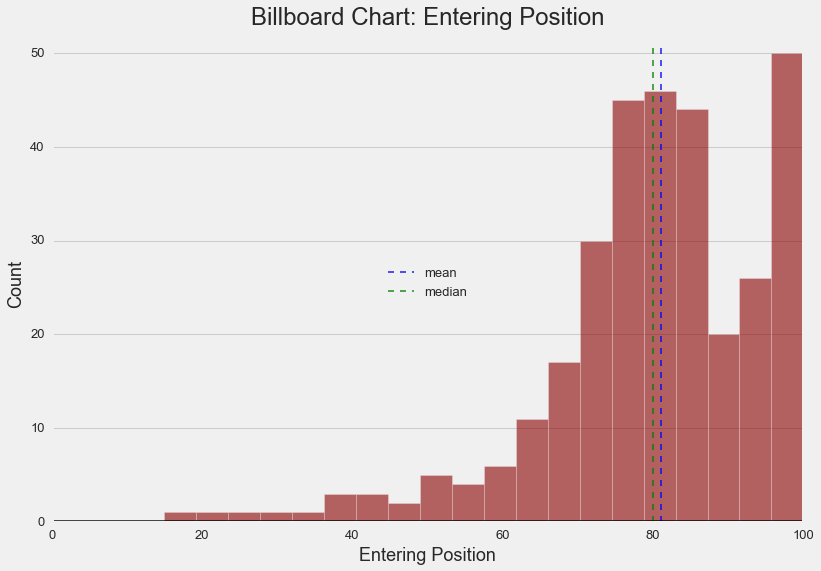

In [22]:
## Plot a histogram of entering chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['entering_position'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['entering_position'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['entering_position'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Entering Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.yticks(range(0, 60, 10), fontsize = 13)
plt.ylim([0, 51])

# x label
plt.xlabel('Entering Position', fontsize = 18)
plt.xticks(range(0, 120, 20), fontsize = 13)
plt.xlim([0, 100])

# legend
plt.legend(loc='center', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black', alpha = 0.7)

plt.show()

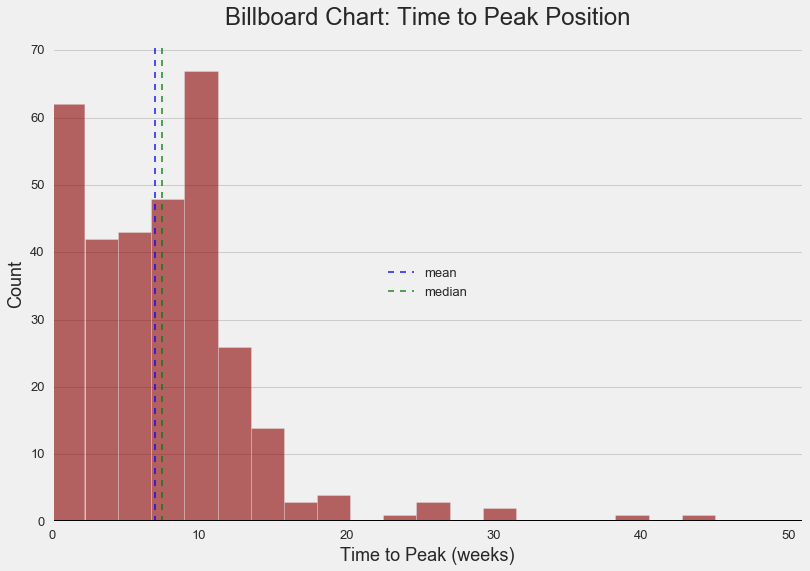

In [23]:
## Plot a histogram of time to peak chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['weeks_to_peak'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['weeks_to_peak'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['weeks_to_peak'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Time to Peak Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.ylim([0, 71])
plt.yticks(range(0, 80, 10), fontsize = 13)

# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)
plt.xlim([0, 51])
plt.xticks(range(0, 60, 10), fontsize = 13)

# legend
plt.legend(loc='center', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

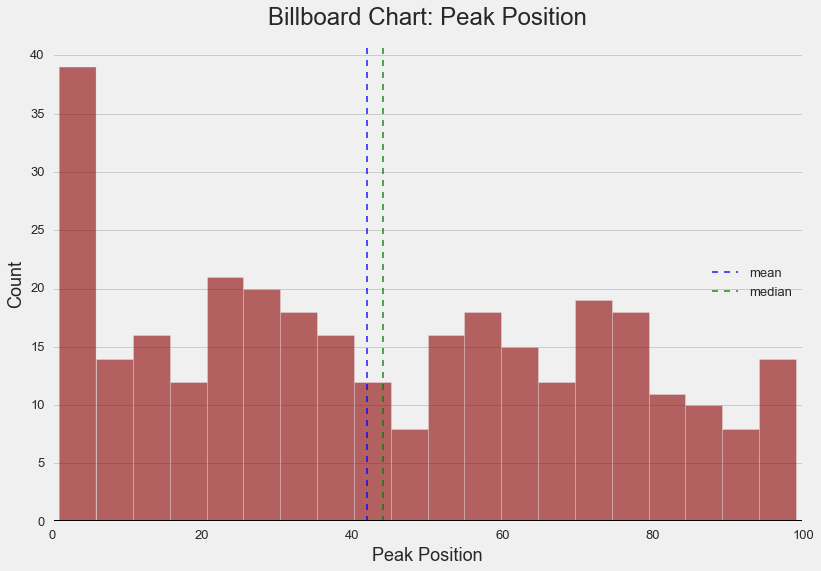

In [24]:
## Plot a histogram of peak chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['peak_position'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['peak_position'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['peak_position'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Peak Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.ylim([0, 41])
plt.yticks(range(0, 45, 5), fontsize = 13)

# x label
plt.xlabel('Peak Position', fontsize = 18)
#plt.xlim([0, 55])
plt.xticks(range(0, 120, 20), fontsize = 13)

# legend
plt.legend(loc='center right', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

This histogram is all over the place!  It appears fairly uniformly distributed except for a spike near the very top chart positions, which probably has to do with marketing and advance hype of certain albums/songs.

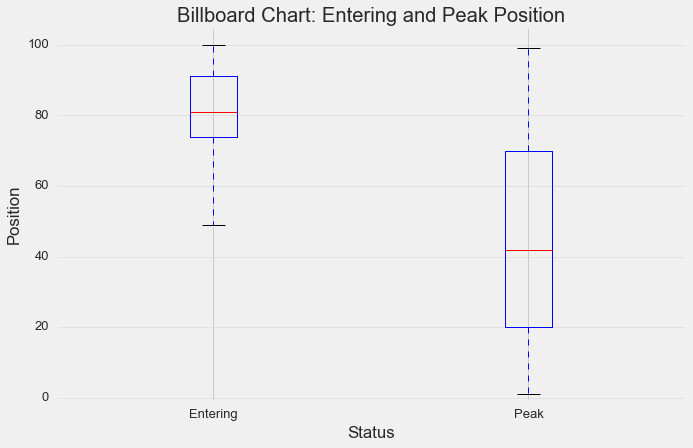

In [25]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(10, 8))

plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

data = [music['entering_position'], music['peak_position']]

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Entering and Peak Position')
ax1.set_xlabel('Status')
ax1.set_ylabel('Position')

# Set the axes ranges and axes labels
numBoxes = 2
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 105)
xtickNames = plt.setp(ax1, xticklabels = ['Entering', 'Peak'])
plt.setp(xtickNames, fontsize=13)
ytickNames = plt.setp(ax1, yticklabels = range(-20, 120, 20)) ## not sure why 0 not working
plt.setp(ytickNames, fontsize=13)

del data 

plt.show()

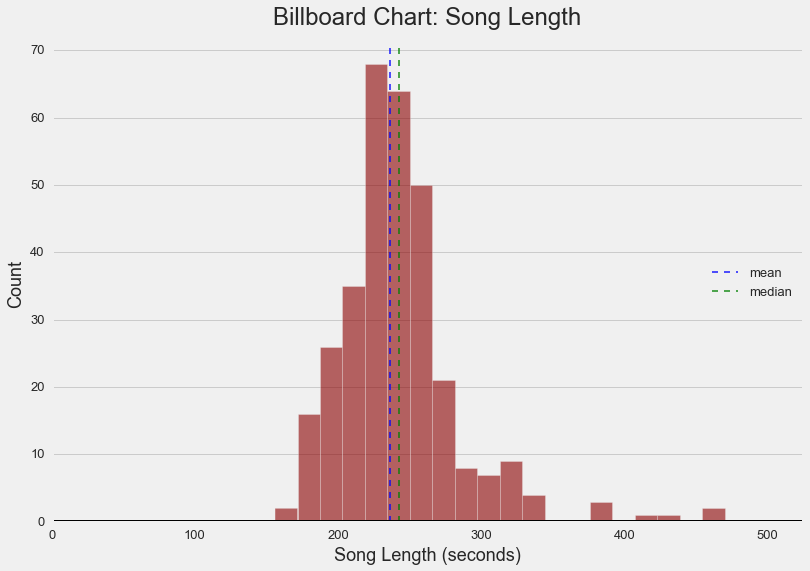

In [26]:
## Plot a histogram of song length 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['time'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['time'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['time'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Song Length', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.ylim([0, 71])
plt.yticks(range(0, 80, 10), fontsize = 13)

# x label
plt.xlabel('Song Length (seconds)', fontsize = 18)
plt.xlim([0, 525])
plt.xticks(range(0, 600, 100), fontsize = 13)

# legend
plt.legend(loc='center right', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

In [27]:
## These are all songs taking longer than 150 days to reach peak chart position
music[music['weeks_to_peak'] > 20][['artist', 'track', 'genre', 'weeks_to_peak']]\
        .sort_values(by = 'weeks_to_peak', ascending = False)

,artist,track,genre,weeks_to_peak
46,Creed,Higher,Rock,45.0
9,Lonestar,Amazed,Country,39.0
24,3 Doors Down,Kryptonite,Rock,31.0
157,Amber,Sexual (Li Da Di),Rock,30.0
13,Creed,With Arms Wide Open,Rock,26.0
28,Joe,I Wanna Know,Rock,26.0
12,Vertical Horizon,Everything You Want,Rock,25.0
17,Faith Hill,Breathe,Rap,24.0


In [28]:
## These are all songs entering the chart at position 30 or better
music[music['entering_position'] < 30][['artist', 'track', 'genre', 'entering_position']]

,artist,track,genre,entering_position
1,Santana,"Maria, Maria",Rock,15.0
45,Pink,There U Go,Rock,25.0
80,Hanson,This Time Around,Country,22.0
114,Mariah Carey,Crybaby,Rock,28.0


Create a genre-color dictionary and a list of all genres:

In [29]:
colors = {'Rock' : 'Red', 
          'Country' : 'Orange', 
          'Rap' : 'Yellow', 
          'R&B' : 'Green', 
          'Electronica' : 'Violet', 
          'Latin' : 'Indigo', 
          'Pop' : 'Blue', 
          'Reggae' : 'DarkGrey', 
          'Jazz' : 'DimGrey', 
          'Gospel' : 'LightGrey'}

genre_list = ['Rock', 'Country', 'Rap', 'R&B', 'Pop', 'Latin', 'Electronica', 'Jazz', \
              'Reggae', 'Gospel']

Define a function to jitter plotted points:

In [30]:
def rand_jitter(arr):
    stdev = 0.005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

Make a column for plot point areas proportional to chart position (larger area --> more favorable position):

In [31]:
peak_area = []
for peak_pos in music['peak_position']:
    x = 100 - peak_pos
    new_peak = ((125 - 10)*(x - min(100 - music['peak_position'])) / \
            (max(100 - music['peak_position']) - min(100 - music['peak_position']))) + 10
    peak_area.append(new_peak)
    
music['peak_area'] = peak_area

del peak_area

Plot time to peak versus song length, with color by genre:

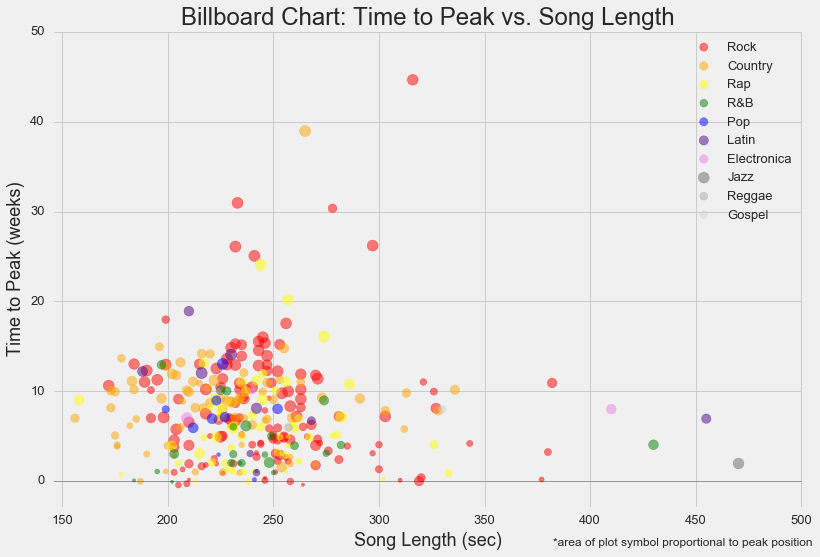

In [32]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genre_list:
    y = music[music['genre'] == i]
    plt.scatter(y['time'], rand_jitter(y['weeks_to_peak']), \
                color = colors[i], alpha = 0.5, s = y['peak_area'], label = i)

plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24)

# y label
plt.ylabel('Time to Peak (weeks)', fontsize = 18)
plt.ylim([-3, 50.25])
plt.yticks(range(0, 60, 10), fontsize = 13)

# x label
plt.xlabel('Song Length (sec)', fontsize = 18)
plt.xlim([145, 501])
plt.xticks(range(150, 550, 50), fontsize = 13)

plt.legend(loc='upper right', fontsize = 13)
plt.axhline(0, color='black', linewidth = 0.5, alpha = 0.5)
plt.axvline(0, color='black')

plt.annotate('*area of plot symbol proportional to peak position', (1,0), (-250, -30), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

plt.show()

Make a column for plot point areas proportional to chart position (larger area --> more favorable position):

In [33]:
time_area = []
for time in music['time']:
    new_time = ((150 - 30)*(time - min(music['time'])) / \
            (max(music['time']) - min(music['time']))) + 30
    time_area.append(new_time)
    
music['time_area'] = time_area

del time_area

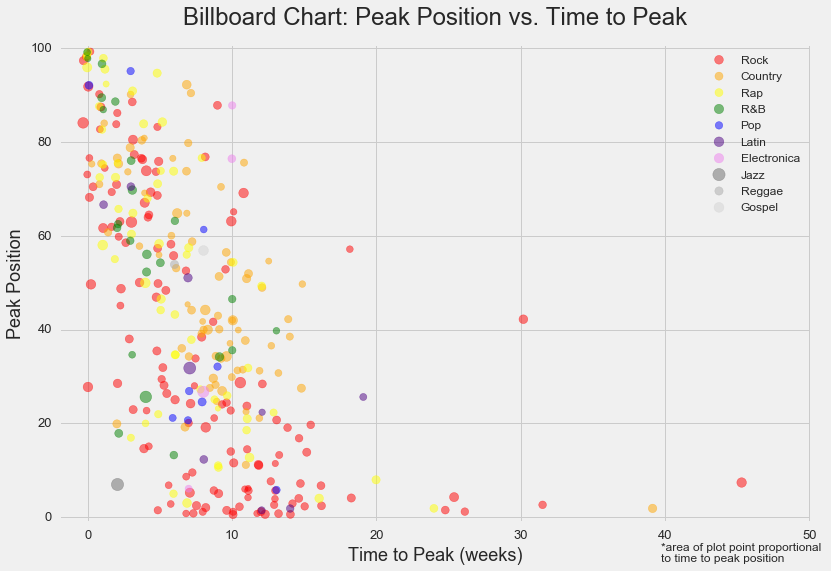

In [34]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genre_list:
    y = music[music['genre'] == i]
    plt.scatter(rand_jitter(y['weeks_to_peak']), rand_jitter(y['peak_position']), \
                color = colors[i], alpha = 0.5, s = y['time_area'], label = i)

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Peak Position', fontsize = 18)
plt.ylim([-1, 101])
plt.yticks(fontsize = 13)

# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)
plt.xlim([-2, 50.09])
plt.xticks(fontsize = 13)

plt.legend(loc='upper right', fontsize = 12)

plt.annotate('*area of plot point proportional \nto time to peak position', (1,0), \
             (-150, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 12)

plt.show()

Seems like not many songs take more than 20 weeks to peak; [investigating](http://www.billboard.com/biz/billboard-charts-legend), we find: 

_"RECURRENT RULES_ 
 
_Descending songs are removed from the Billboard Hot 100 and Hot 100 Airplay simultaneously after 20 weeks on the Billboard Hot 100 and if ranking below No. 50."_

In [35]:
music = music[music['weeks_to_peak'] <= 20]

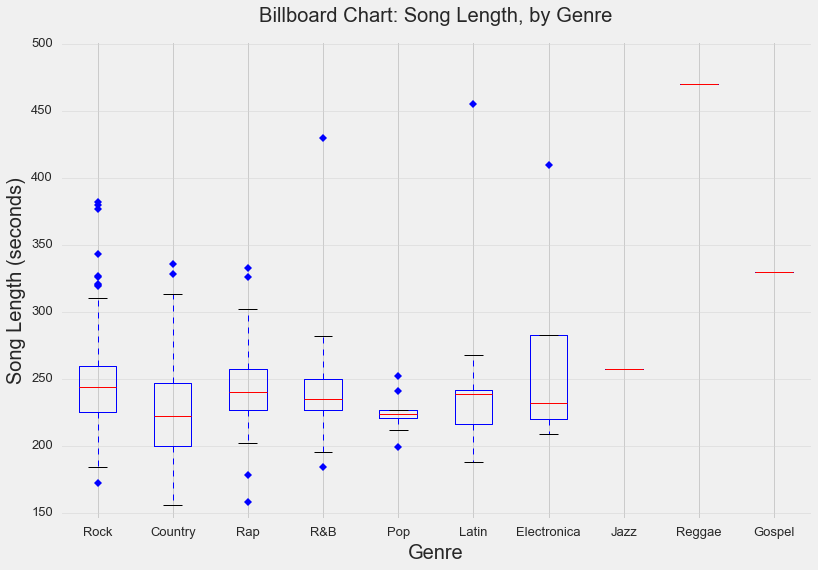

In [36]:
## SONG LENGTH
## all genres: yes
## cleaned: no

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [music[music['genre'] == 'Rock']['time'], \
        music[music['genre'] == 'Country']['time'], \
        music[music['genre'] == 'Rap']['time'],
        music[music['genre'] == 'R&B']['time'],
        music[music['genre'] == 'Pop']['time'],
        music[music['genre'] == 'Latin']['time'],
        music[music['genre'] == 'Electronica']['time'],
        music[music['genre'] == 'Reggae']['time'],
        music[music['genre'] == 'Jazz']['time'],
        music[music['genre'] == 'Gospel']['time']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Song Length, by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Song Length (seconds)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(145, 502)
xtickNames = plt.setp(ax1, xticklabels = genre_list)
plt.setp(xtickNames, fontsize = 13)
ytickNames = plt.setp(ax1, yticklabels = range(100, 550, 50))
plt.setp(ytickNames, fontsize = 13)

del data

plt.show()

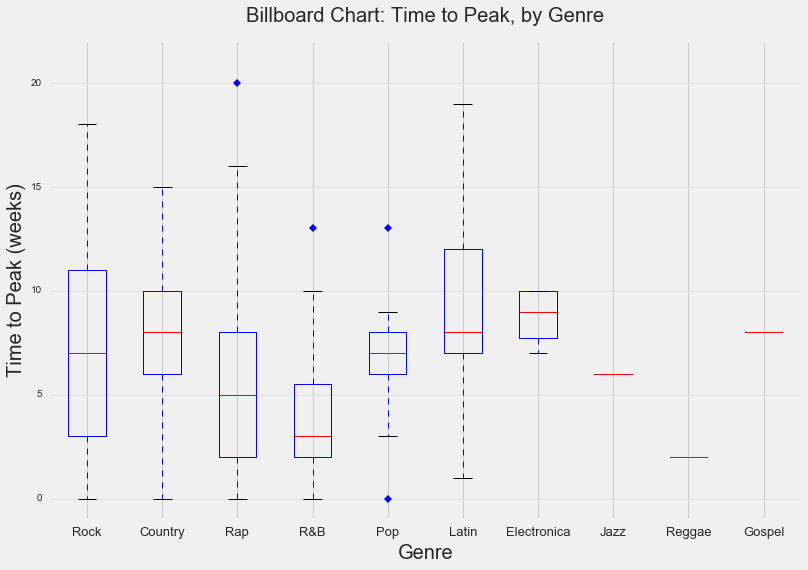

In [37]:
## WEEKS TO PEAK
## all genres: yes
## cleaned: no

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [music[music['genre'] == 'Rock']['weeks_to_peak'], \
        music[music['genre'] == 'Country']['weeks_to_peak'], \
        music[music['genre'] == 'Rap']['weeks_to_peak'],
        music[music['genre'] == 'R&B']['weeks_to_peak'],
        music[music['genre'] == 'Pop']['weeks_to_peak'],
        music[music['genre'] == 'Latin']['weeks_to_peak'],
        music[music['genre'] == 'Electronica']['weeks_to_peak'],
        music[music['genre'] == 'Reggae']['weeks_to_peak'],
        music[music['genre'] == 'Jazz']['weeks_to_peak'],
        music[music['genre'] == 'Gospel']['weeks_to_peak']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Time to Peak, by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Time to Peak (weeks)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 22)
xtickNames = plt.setp(ax1, xticklabels = genre_list)
plt.setp(xtickNames, fontsize = 13)
#ytickNames = plt.setp(ax1, yticklabels = range(0, 30, 10))
plt.setp(ytickNames, fontsize=13)

del data

plt.show()

### Clean data:

In [38]:
genrelets = ['Reggae', 'Gospel', 'Jazz']

for genre in genrelets:
    music = music[music['genre'] != genre]

genres = list(music['genre'].value_counts(ascending = False).index)
for i in genrelets:
    genres.remove(i)
genres

['Rock', 'Country', 'Rap', 'R&B', 'Pop', 'Latin', 'Electronica']

In [39]:
clean_music = pd.DataFrame()
for i in genres:
    lil_music = music[music['genre'] == i][np.abs(music['time'] - \
            music['time'].mean())<=(3*music['time'].std())]
    lil_music = lil_music[lil_music['genre'] == i][np.abs(lil_music['weeks_to_peak'] - \
            lil_music['weeks_to_peak'].mean())<=(3*lil_music['weeks_to_peak'].std())]    
    clean_music = pd.concat([clean_music, lil_music], axis = 0)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


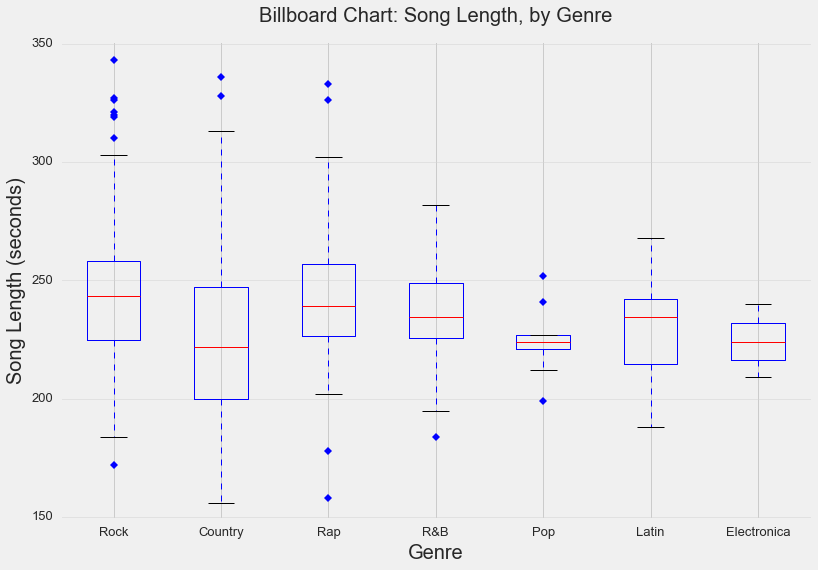

In [40]:
## SONG LENGTH
## all genres: no
## cleaned: yes

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [clean_music[clean_music['genre'] == 'Rock']['time'], \
        clean_music[clean_music['genre'] == 'Country']['time'],
        clean_music[clean_music['genre'] == 'Rap']['time'],
        clean_music[clean_music['genre'] == 'R&B']['time'],
        clean_music[clean_music['genre'] == 'Pop']['time'],
        clean_music[clean_music['genre'] == 'Latin']['time'],
        clean_music[clean_music['genre'] == 'Electronica']['time']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Song Length, by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Song Length (seconds)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(clean_music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(149, 351)
xtickNames = plt.setp(ax1, xticklabels = genres)
plt.setp(xtickNames, fontsize = 13)
ytickNames = plt.setp(ax1, yticklabels = range(100, 400, 50))
plt.setp(ytickNames, fontsize = 13)

del data

plt.show()

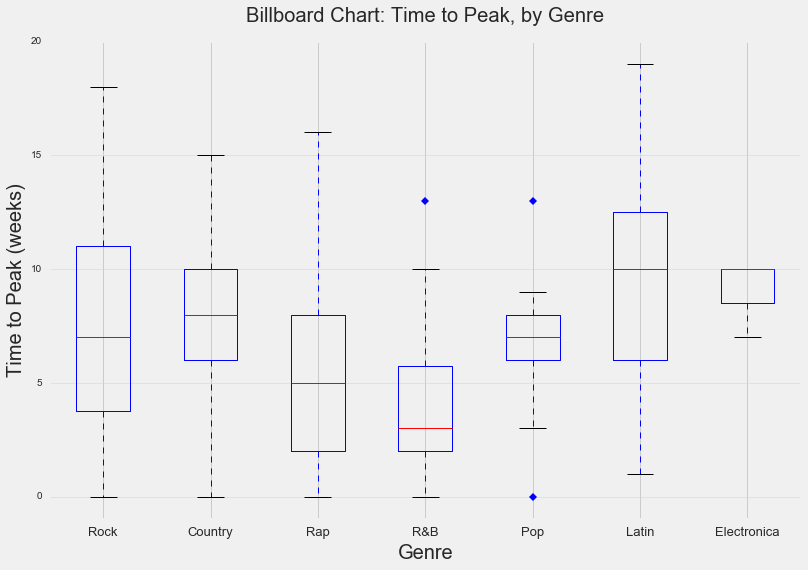

In [41]:
## WEEKS TO PEAK
## all genres: no
## cleaned: yes

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [clean_music[clean_music['genre'] == 'Rock']['weeks_to_peak'], \
        clean_music[clean_music['genre'] == 'Country']['weeks_to_peak'],
        clean_music[clean_music['genre'] == 'Rap']['weeks_to_peak'],
        clean_music[clean_music['genre'] == 'R&B']['weeks_to_peak'],
        clean_music[clean_music['genre'] == 'Pop']['weeks_to_peak'],
        clean_music[clean_music['genre'] == 'Latin']['weeks_to_peak'],
        clean_music[clean_music['genre'] == 'Electronica']['weeks_to_peak']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Time to Peak, by Genre', y = 1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Time to Peak (weeks)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(clean_music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 20)
xtickNames = plt.setp(ax1, xticklabels = genres)
plt.setp(xtickNames, fontsize = 13)
#ytickNames = plt.setp(ax1, yticklabels = range(-5, 40, 5))
plt.setp(ytickNames, fontsize=13)

del data

plt.show()

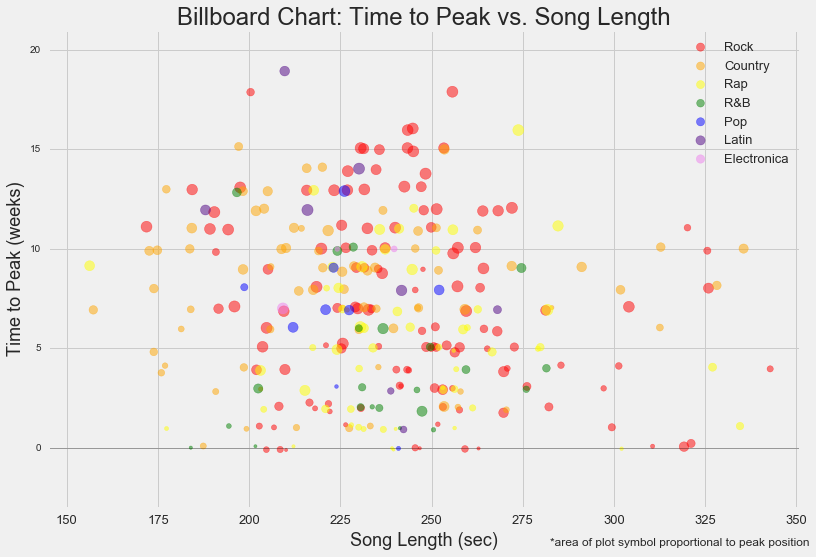

In [42]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genres:
    y = clean_music[clean_music['genre'] == i]
    plt.scatter(rand_jitter(y['time']), rand_jitter(y['weeks_to_peak']), \
                color = colors[i], alpha = 0.5, s = y['peak_area'], label = i)

plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24)

# y label
plt.ylabel('Time to Peak (weeks)', fontsize = 18)
plt.ylim([-3, 21])
#plt.yticks(range(0, 60, 10), fontsize = 13)

# x label
plt.xlabel('Song Length (sec)', fontsize = 18)
plt.xlim([145, 351])
plt.xticks(range(150, 375, 25), fontsize = 13)

plt.legend(loc='upper right', fontsize = 13)
plt.axhline(0, color='black', linewidth = 0.5, alpha = 0.5)

plt.annotate('*area of plot symbol proportional to peak position', (1,0), (-250, -30), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

plt.show()

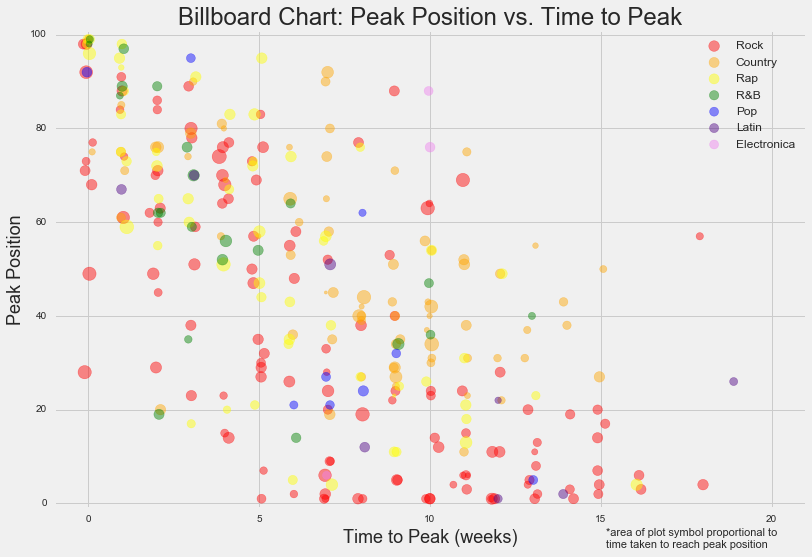

In [43]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

time_area = []
for time in clean_music['time']:
    new_time = ((200 - 10)*(time - min(clean_music['time'])) / \
            (max(clean_music['time']) - min(clean_music['time']))) + 10
    time_area.append(new_time)
    
clean_music['time_area'] = time_area

del time_area

for i in genres:
    try:
        y = clean_music[clean_music['genre'] == i]
        plt.scatter(rand_jitter(y['weeks_to_peak']), \
                    y['peak_position'], color = colors[i], \
                    alpha = 0.45, s = y['time_area'], label = i)
    except:
        pass

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24)

# y label
plt.ylabel('Peak Position', fontsize = 18)

# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)

# set the figure boundaries
plt.xlim([-1, 21])
plt.ylim([-1, 101])

plt.legend(loc='upper right', fontsize = 12)

plt.annotate('*area of plot symbol proportional to \ntime taken to reach peak position', \
             (1,0), (-200, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 11)

plt.show()

In [44]:
clean_music.reset_index(drop = False, inplace = True)

We hypothesize that there is a linear relationship at a 0.05 significance level between the amount of time it takes a song to reach its peak position on the Billboard chart and the peak position itself.  We will test against the null hypothesis that the slope of the regression line is equal to zero.

For regression line: 

        y = Β0 + Β1x

H0: Β1 = 0

Ha: Β1 ≠ 0

In [65]:
X = clean_music[['weeks_to_peak']]
X = sm.add_constant(X)
#X = pd.DataFrame(StandardScaler(with_mean = 0, with_std = 1, copy = False).fit_transform(X))
X.columns = ['constant', 'weeks_to_peak']
y = clean_music['peak_position']
ols = sm.OLS(y, X)

ols_result = ols.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          peak_position   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     226.7
Date:                Fri, 24 Feb 2017   Prob (F-statistic):           1.86e-38
Time:                        01:59:07   Log-Likelihood:                -1346.3
No. Observations:                 299   AIC:                             2697.
Df Residuals:                     297   BIC:                             2704.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
constant         75.4193      2.369     31.837      0.000        70.757    80.081
weeks_to_peak    -4.3932      0.292    -15.055      0.000        -4.967    -3.819
==============================================================================
Omnibus:                        1.089   Durbin-Watson:                   0.845
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.161
Skew:                          -0.089   Prob(JB):                        0.560
Kurtosis:                       2.751   Cond. No.                         15.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
print 'Parameters: '
print ols_result.params, '\n'
print 'R2: ' 
print ols_result.rsquared

Parameters: 
constant         75.419281
weeks_to_peak    -4.393157
dtype: float64 

R2: 
0.432845951301


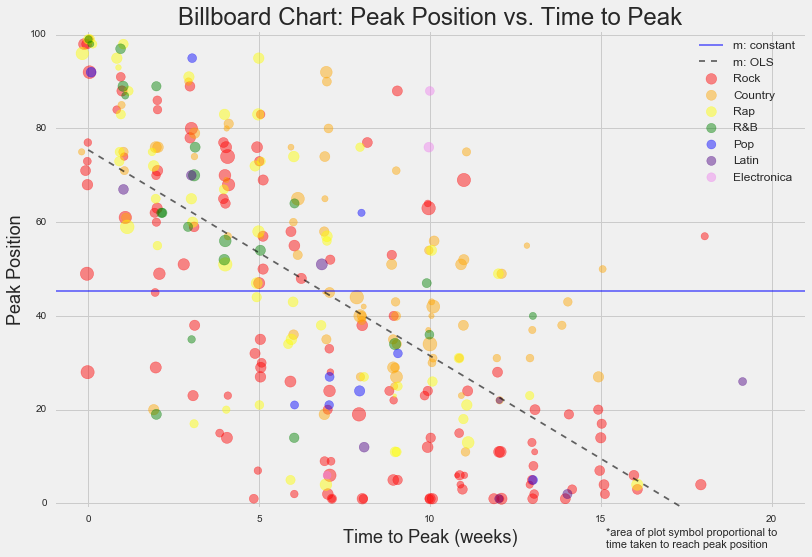

In [72]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

time_area = []
for time in clean_music['time']:
    new_time = ((200 - 10)*(time - min(clean_music['time'])) / \
            (max(clean_music['time']) - min(clean_music['time']))) + 10
    time_area.append(new_time)
    
clean_music['time_area'] = time_area

del time_area

for i in genres:
    try:
        y = clean_music[clean_music['genre'] == i]
        plt.scatter(rand_jitter(y['weeks_to_peak']), \
                    y['peak_position'], color = colors[i], \
                    alpha = 0.45, s = y['time_area'], label = i)
    except:
        pass

x = np.arange(0, 20, 0.5)
m = round(ols_result.params[1], 2)
b = ols_result.params[0]

plt.axhline(clean_music['peak_position'].mean(), alpha = 0.5, linewidth = 2, label = 'm: constant')
plt.plot(x, m*x + b, '--', linewidth = 1.75, color = 'black', alpha = 0.6, label = 'm: OLS')
plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24)

# y label
plt.ylabel('Peak Position', fontsize = 18)

# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)

# set the figure boundaries
plt.xlim([-1, 21])
plt.ylim([-1, 101])

plt.legend(loc='upper right', fontsize = 12)

plt.annotate('*area of plot symbol proportional to \ntime taken to reach peak position', \
             (1,0), (-200, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 11)

plt.show()

Thus, since p-value << 0.05 for the coefficient, we reject the null hypothesis that there is no linear relationship between the amount of time it takes a song to peak on the Billboard chart and the final position.  It appears as though the long a song takes, the more favorable the peak position is.  (NB this only applies to songs that take less than 20 weeks to reach peak position, because of special Billboard policy referenced above.)